# Report Classification Task
We will segregate into 4 different smaller reports followed by a summary that goes into similarities and differences between the data sets and algorithems used.

We dropped the classification dataset from project 0, as it had genome sequences as only factors, as we want to focus on coding we strived for an easier to understand set of input variables.

We choose the following as our three classifiers:  
Random Forests - they are relatively straight forwards, it would be interesting to see how this rather simple algorithmen performes against more complex ones.  
KNN - has the interesting property of using metrics so it leaves a lot of room for playing with the models.
?? - ??

In [74]:
#We import the following packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score


#and set the following variables we will use frequently:
seed = 69

## Heart Attack Analysis & Prediction Dataset

#### Description
The dataset's objective is to predict the likelihood of a heart attack, where the target variable distinguishes between lower risk (0) and higher risk (1).
This dataset of 10 features, excluding the target, includes:
Categorical Variables: These include Sex, exang (exercise-induced angina), fbs (fasting blood sugar), and rest_ecg (electrocardiographic results).
Ordinal Variables: cp (chest pain type) and ca (number of major vessels), both of which imply a ranked order of severity or count.
Numerical Variables: Continuous measurements such as Age, trtbps (resting blood pressure), chol (cholesterol level), and thalach (maximum heart rate achieved).

For each numerical column, we calculate the Interquartile Range (IQR) and use it to determine outliers as values lying outside 1.5 times the IQR from the first and third quartiles.

First 5 rows of the dataset:
    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  

Missing values per variable:
 age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Summary statistics:
               age         sex          cp      trtbps        chol         fbs  \
count  303.000000  3

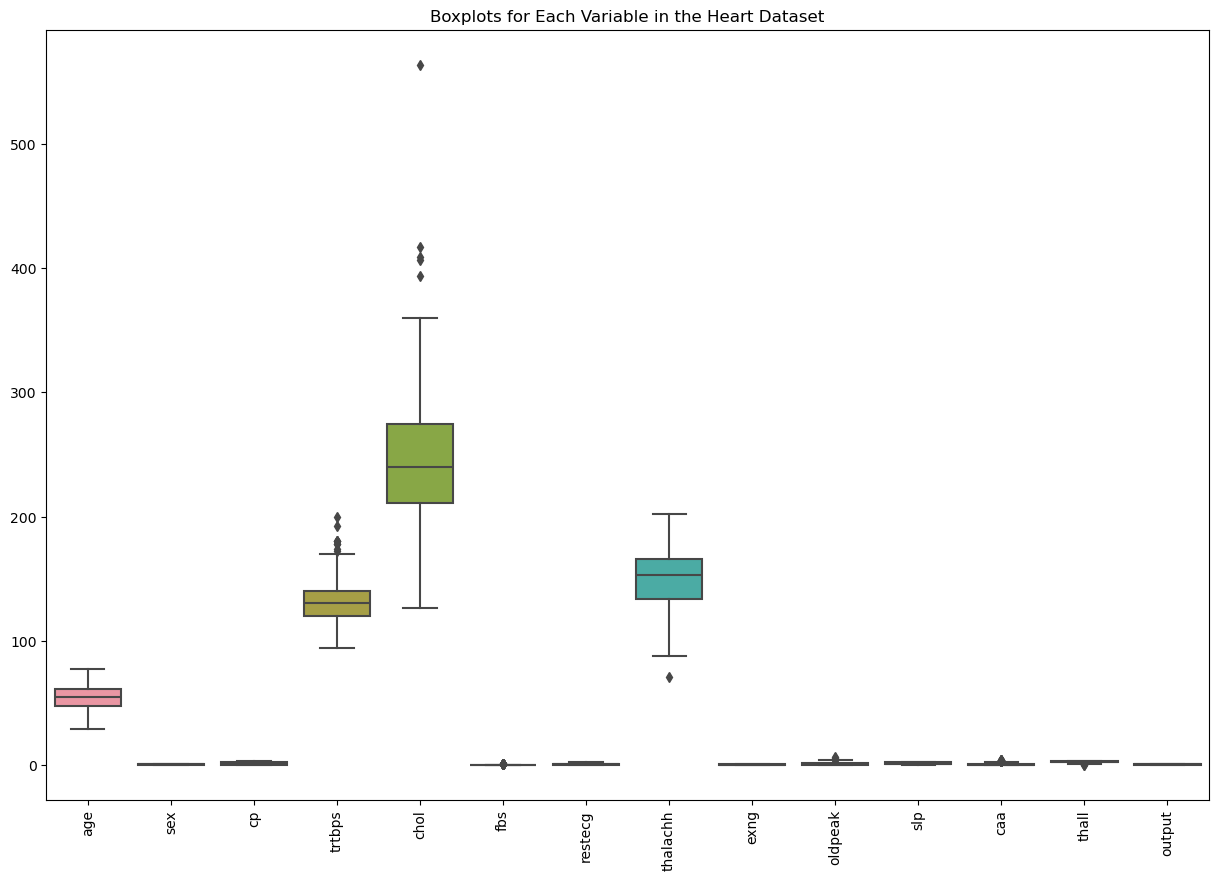

In [75]:
heart = pd.read_csv("data/heart.csv", sep=',')

print("First 5 rows of the dataset:\n", heart.head())
print("\nMissing values per variable:\n", heart.isna().sum())
print("\nSummary statistics:\n", heart.describe())

#detect outliers using the IQR method
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include='number').columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = detect_outliers(heart)

for column, outlier_df in outliers.items():
    print(f"\nOutliers in {column}:\n", outlier_df)

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=heart)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show() 

### Handling Outliers and NAs
To address the varying scales of the continuous variables in the dataset, we applied Min-Max Scaling to normalize the features trtbps (resting blood pressure), thalachh (maximum heart rate achieved), and oldpeak (previous peak) to a [0, 1] range. This transformation standardizes the scale of these variables, allowing them to contribute comparably to the model and improving model performance by reducing the influence of different measurement units.

For the chol (cholesterol) feature, we used Robust Scaling instead of Min-Max Scaling, given that chol contains significant outliers that could disproportionately affect scaling. Robust Scaling relies on the median and interquartile range (IQR), making it less sensitive to extreme values and thus more suitable for this variable. By using this scaling method for chol, we minimize the impact of outliers while still adjusting the feature to a common scale for improved model performance.

The detected outliers that remain untreated are caa, fbs, and thalachh. The variables caa and fbs are class variables, so they were left as is to preserve their categorical nature and meaningful interpretation. In the case of thalachh, only a single outlier was detected, and it was not particularly extreme as observed in the histogram. Given its minimal impact on the overall distribution, it was deemed unnecessary to apply specific treatment for this outlier, allowing the value to remain in the dataset without distorting scaling or model performance.

First 5 rows of the dataset:
    age  sex  cp    trtbps      chol  fbs  restecg  thalachh  exng   oldpeak  \
0   63    1   3  0.481132 -0.110236    1        0       150     0  0.370968   
1   37    1   2  0.339623  0.157480    0        1       187     0  0.564516   
2   41    0   1  0.339623 -0.566929    0        0       172     0  0.225806   
3   56    1   1  0.245283 -0.062992    0        1       178     0  0.129032   
4   57    0   0  0.245283  1.795276    0        1       163     1  0.096774   

   slp  caa  thall  output  
0    0    0      1       1  
1    0    0      2       1  
2    2    0      2       1  
3    2    0      2       1  
4    2    0      2       1  


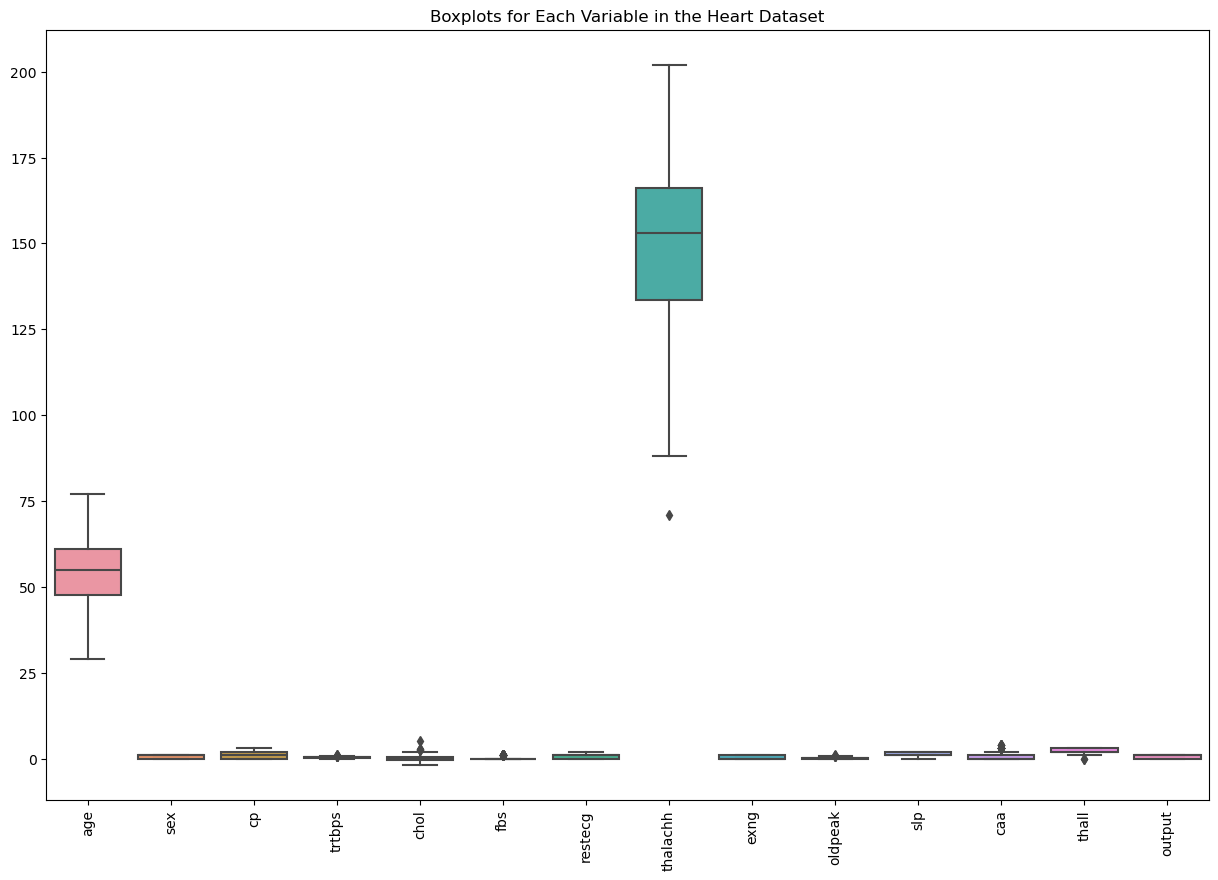

In [76]:
scaler = MinMaxScaler()
heart[['trtbps', 'oldpeak']] = scaler.fit_transform(heart[['trtbps', 'oldpeak']])

scaler = RobustScaler()
heart[['chol']] = scaler.fit_transform(heart[['chol']])

print("First 5 rows of the dataset:\n", heart.head())

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=heart)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show()

### Classifier #1: Random Forest
We try out the random forest first. Below is an overview of the main hyperparameters used in this model.

Explicitly Defined Hyperparameters:  
n_estimators - This parameter defines the number of trees in the forest. Using 100 trees provides sufficient ensemble diversity, helping to reduce overfitting while maintaining computational efficiency. This choice was based on a stackexchange discussion: https://stackoverflow.com/questions/34997134/random-forest-tuning-tree-depth-and-number-of-trees. Eventhough this does not exactly apply to our setting, it helps to get a sense for a proper value.

criterion = 'gini': The Gini impurity criterion measures the quality of each split, aiming to increase node purity by favoring partitions with homogenous classes. Although Information Gain (entropy) was considered, it was noted in the lecture that Gini performs similarly in many classification tasks and is computationally efficient. This made Gini a suitable choice for this model.

max_depth - We need to set some limit to the depth of the trees such that we can assure finite computation time. We actually put in place a better suited method as stopping criterion, the impurity decrease.

min_impurity_decrease - This parameter stops further splitting if the reduction in impurity (analogous to Information Gain with criterion='entropy', which we discussed more intensively in the lecture) is below a given threshhold. By setting a minimum threshold for impurity decrease, we avoid creating splits that add minimal information, further controlling tree complexity and enhancing the model’s ability to generalize.

Default Hyperparameters:  
max_features = 'sqrt': The number of features considered for splitting at each node is limited to the square root of the total features. This default setting enhances model diversity by allowing each tree to focus on different subsets of features, reducing overfitting and improving training efficiency.
In this setup, both explicitly defined and default parameters are used to optimize the model’s performance. The adjustments to max_depth and min_impurity_decrease prevent overfitting by limiting unnecessary splits, while n_estimators and criterion maintain model robustness and accuracy. Together, these parameters provide a balanced approach, capturing relevant patterns in the data without overly complex trees.

In [77]:
#define features and target variable
features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall']

X = heart[features]
y = heart['output']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#initialize and train the Random Forest model
n_of_trees = 100 #https://stackoverflow.com/questions/34997134/random-forest-tuning-tree-depth-and-number-of-trees
rf_model = RandomForestClassifier(
    n_estimators=n_of_trees,
    random_state=seed,  #seed for reproducibility
    bootstrap=True,
    criterion='gini',  # Use impurity as the splitting criterion as information gain stopping criterion is not available which we covered more intensively in the lecture.
    max_depth=20,  #nevertheless we need a definitive stopping criterion
    min_impurity_decrease=0.1  #stop splitting when Information Gain is below 0.1 this workes really well for my test set in comparisson to 0.02 for example
)
rf_model.fit(X_train, y_train)

#Evaluate performance
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8901098901098901

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        41
           1       0.87      0.94      0.90        50

    accuracy                           0.89        91
   macro avg       0.89      0.88      0.89        91
weighted avg       0.89      0.89      0.89        91



Class 0 (No Heart Disease): Precision is 0.92, meaning the model is very accurate when it predicts no heart disease, though recall is slightly lower at 0.83. We do not prioritize this metric as much since we prefer being overly cautious, even if it means sacrificing some accuracy in identifying people without heart disease.

Class 1 (Heart Disease): Precision is 0.87, and recall is high at 0.94. The high recall for heart disease means the model is effective at capturing most true positives (actual heart disease cases) with few false negatives. This is desirable, as we want to avoid missing heart disease cases.

We experimented with specifying the voting system explicitly, testing Majority Voting, Probability Averaging (Soft Voting), and Weighted Voting. Interestingly, both Majority Voting and Probability Averaging (Soft Voting) resulted in the same classification report. Since scikit-learn does not directly support weighted voting within RandomForestClassifier, implementing it would require additional custom coding. However, we believe the performance gain from weighted voting would likely be marginal, perhaps even statistically insignificant, so we chose not to pursue further adjustments to the weighting scheme for Random Forest.

We thought it would still be interesting to understand how Majority Voting, Probability Averaging (Soft Voting), and Weighted Voting work, so we provide a brief summary below.

Summary of Voting Methods  
Majority Voting: This is the standard approach we also covered in the lecture where each tree in the ensemble votes for a class, and the class with the most votes is selected as the final prediction. This method is simple and effective, leveraging the collective "wisdom" of all trees to make a robust prediction.

Probability Averaging (Soft Voting): Instead of voting directly on the predicted class, each tree provides a probability distribution over all classes. The model then averages these probabilities across all trees and selects the class with the highest average probability. Soft voting takes each tree’s confidence into account, which can improve performance in cases where some trees are more certain than others. This should be an improvement of the typical majority vote.

Weighted Voting: In weighted voting, each tree’s vote is given a different weight based on certain criteria, such as its accuracy. Trees with better performance (e.g., higher accuracy on a validation set) contribute more to the final prediction, enhancing the model’s robustness. Though we opted not to implement this method, it can be particularly useful when certain trees consistently perform better in identifying specific patterns.

### Classifier #2: K-Nearest Neighbors (KNN)
We also experimented with the K-Nearest Neighbors (KNN) algorithm, which we covered in the lecture as an intuitive yet powerful method for classification tasks. KNN is a non-parametric, instance-based learning method that predicts the class of a sample based on the majority class among its nearest neighbors. For our project, we used KNN to predict the likelihood of heart disease (yes or no), leveraging the proximity of data points in feature space to make decisions.

Explicitly Defined Hyperparameters  
n_neighbors: This parameter determines the number of neighbors to consider when making a prediction. We tested different values to find an optimal balance; lower values (like 3-5) focus on very local patterns, while higher values (10+) consider a broader view of the data. Since heart disease prediction is a high-stakes application, tuning n_neighbors helps us control the model’s sensitivity and generalization.

weights: The weights parameter allows us to choose between uniform and distance-based voting among neighbors. With weights='uniform', each neighbor has an equal vote, whereas weights='distance' gives closer neighbors more influence. Distance weighting can be beneficial when predicting health outcomes, as patients with similar characteristics are likely to have similar diagnoses, and closer instances may hold more relevant information.

metric: The distance metric (e.g., Euclidean, Manhattan) determines how "closeness" is calculated. Euclidean distance is commonly used in KNN, but other metrics like Manhattan or Minkowski distance can be explored to see if they provide better alignment with the dataset’s feature structure.

Default Parameters and Considerations
KNN uses a lazy learning approach, where computation occurs at prediction time rather than during training. This means that KNN can be computationally expensive for large datasets. However, because our dataset for heart disease prediction is manageable in size, KNN remains a feasible option.

While KNN is simpler than ensemble methods like Random Forest, it is sensitive to the choice of n_neighbors and the distance metric. Both of these parameters can significantly impact its accuracy and should be chosen carefully. In this setup, tuning n_neighbors and using distance-weighted voting provided more refined predictions by capturing the proximity relationships relevant to heart disease classification.

In [78]:
#define features and target variable
features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
            'exng', 'oldpeak', 'slp', 'caa', 'thall']

X = heart[features]
y = heart['output']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#initialize and train the KNN model
k_neighbors = 7
knn_model = KNeighborsClassifier(
    n_neighbors=k_neighbors,
    weights='distance',
    metric='euclidean'
)
knn_model.fit(X_train, y_train)

#evaluate performance
y_pred = knn_model.predict(X_test)

print("Hyperparameters chosen:\nk_neighbors =", k_neighbors, ", weights = 'distance', metric = 'euclidean'")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Hyperparameters chosen:
k_neighbors = 7 , weights = 'distance', metric = 'euclidean'

Accuracy: 0.7472527472527473

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        41
           1       0.80      0.72      0.76        50

    accuracy                           0.75        91
   macro avg       0.75      0.75      0.75        91
weighted avg       0.75      0.75      0.75        91



Since these initial values are not too convincing, we proceed with an optimization task to try out different values for k_neighbors. To find the optimal k_neighbors value that maximizes precision for Class 1 (heart disease), we perform a grid search over a range of k_neighbors values. By specifying a custom scoring function focused on Class 1 precision, we aim to reduce false positives and, more importantly, false negatives, which are critical to avoid in heart disease diagnosis. And, of course, we also pray to the data science gods that this doesn’t lead to dramatic overfitting.

The precision for Class 1 is calculated as:
\[
\text{Precision (Class 1)} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\]

In [79]:
#define features and target variable
features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
            'exng', 'oldpeak', 'slp', 'caa', 'thall']

X = heart[features]
y = heart['output']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#define a custom scorer for precision in Class 1
precision_scorer = make_scorer(precision_score, pos_label=1)

# Define parameter grid for k_neighbors
param_grid = {
    'n_neighbors': range(1, 21),  #test values of k from 1 to 20
    'weights': ['distance'],
    'metric': ['euclidean']
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring=precision_scorer,  #optimize based on precision in Class 1
    cv=5  #5-fold cross-validation, splits the data into 5 parts, trains on 4 parts, and tests on the 5th, rotating so each part is used once as a test set
)
grid_search.fit(X_train, y_train)

#retrieve the best model and evaluate it on the test set
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

#print best hyperparameters and evaluation metrics
print("Best Hyperparameters:\n", grid_search.best_params_)
print("\nOptimized for Class 1 Precision:")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters:
 {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}

Optimized for Class 1 Precision:

Accuracy: 0.7472527472527473

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        41
           1       0.80      0.72      0.76        50

    accuracy                           0.75        91
   macro avg       0.75      0.75      0.75        91
weighted avg       0.75      0.75      0.75        91



Apparently, the data science gods listened to our prayers, as this actually improves the precision of Class 1 while leaving accuracy unchanged. This is promising because it shows we can maximize precision for Class 1 without falling into the obvious pitfall of simply classifying all patients as having heart disease. Encouraged by this, we proceed to try out another approach.

Since we didn’t check for feature covariation, Mahalanobis distance could be valuable here. Unlike Euclidean distance, Mahalanobis accounts for correlations and scales distances based on feature variances, making it ideal when features are on different scales or are correlated.

In [80]:
#define features and target variable
features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
            'exng', 'oldpeak', 'slp', 'caa', 'thall']

X = heart[features]
y = heart['output']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#initialize and train the KNN model with Mahalanobis distance
cov_matrix = np.cov(X_train, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

k_neighbors = 7
knn_model = KNeighborsClassifier(
    n_neighbors=k_neighbors,
    weights='distance',
    metric='mahalanobis',
    metric_params={'V': inv_cov_matrix}  # Provide inverse covariance matrix for Mahalanobis distance
)
knn_model.fit(X_train, y_train)

#evaluate performance
y_pred = knn_model.predict(X_test)

print("Hyperparameters chosen:\nk_neighbors =", k_neighbors, ", weights = 'distance', metric = 'mahalanobis'")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Hyperparameters chosen:
k_neighbors = 7 , weights = 'distance', metric = 'mahalanobis'

Accuracy: 0.7142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.76      0.70        41
           1       0.77      0.68      0.72        50

    accuracy                           0.71        91
   macro avg       0.72      0.72      0.71        91
weighted avg       0.72      0.71      0.71        91



Evaluating the results, we found that Mahalanobis distance did not improve either accuracy or Class 1 precision. Although the results are similar, we interpret this as an indication that variable covariance does not significantly impact the model’s performance.

Overall, across all tested KNN modifications, we were unable to achieve an accuracy above 70%, leading us to conclude that our model is not sufficiently reliable for heart disease diagnosis.

## Loan

## Flight Status Prediction

## Breast Cancer

### Description
The variables in this dataset are derived from features of cell nuclei in breast cancer biopsy images, providing critical measurements for distinguishing between benign and malignant tumors. Here’s a brief overview of each variable:

Diagnostic Label:  
class: Represents the diagnosis of the tumor, where 0 indicates a benign (non-cancerous) tumor and 1 indicates a malignant (cancerous) tumor.

Mean Measurements - These represent the average values for each feature across multiple nuclei in a sample:  
radiusMean: Average distance from the center to the perimeter of cell nuclei, indicating cell size.
textureMean: Mean texture score quantifying variance in gray levels in the nucleus; high variance may indicate irregular cell structures.
perimeterMean: Mean perimeter of the nucleus, with larger values potentially indicating irregular and possibly malignant cells.
areaMean: Average area of the cell nuclei, indicating overall size.
smoothnessMean: Calculated by measuring local variation in radius lengths; lower smoothness can signal irregularity and potential malignancy.
compactnessMean: A ratio of perimeter squared to area, with higher values suggesting a more irregular cell shape.
concavityMean: Average severity of concave portions of the nuclear contour, indicating irregularities.
concavePointsMean: Average number of concave points on the nuclear contour, which may suggest abnormal shapes.
symmetryMean: Average symmetry of the cell nuclei; less symmetry may indicate malignancy.
fractalDimensionMean: Measure of the complexity of cell nucleus shape, capturing detail across scales.

Standard Error Measurements - These values capture variability for each feature across multiple nuclei in the sample:  
radiusStdErr: Standard error of radius measurements, indicating variability.
textureStdErr: Standard error of texture measurements.
perimeterStdErr: Standard error of perimeter measurements.
areaStdErr: Standard error of area measurements.
smoothnessStdErr: Standard error of smoothness measurements.
compactnessStdErr: Standard error of compactness measurements.
concavityStdErr: Standard error of concavity measurements.
concavePointsStdErr: Standard error of concave points measurements.
symmetryStdErr: Standard error of symmetry measurements.
fractalDimensionStdErr: Standard error of fractal dimension measurements.

"Worst" (Maximum) Measurements - These variables represent the largest or most extreme value for each feature observed among the nuclei in a sample:  
radiusWorst: Largest radius observed, indicating the largest cells.
textureWorst: Highest texture score, showing the most varied or irregular texture.
perimeterWorst: Longest perimeter measurement, indicating the most extensive nucleus outline.
areaWorst: Largest area measured, representing the biggest cell.
smoothnessWorst: Highest smoothness value, indicating minimal variation in radius.
compactnessWorst: Highest compactness value, indicating irregular shape.
concavityWorst: Most pronounced concavity in the nuclear contour.
concavePointsWorst: Highest count of concave points on the perimeter, suggesting an irregular shape.
symmetryWorst: Highest symmetry measurement.
fractalDimensionWorst: Highest fractal dimension, indicating the roughest or most complex boundary.

First 5 rows of the dataset:
    class  radiusMean  textureMean  perimeterMean  areaMean  smoothnessMean  \
0   True       13.96        17.05          91.43     602.4         0.10960   
1   True       11.42        20.38          77.58     386.1         0.14250   
2   True       21.37        15.10         141.30    1386.0         0.10010   
3   True       18.22        18.87         118.70    1027.0         0.09746   
4  False       15.71        13.93         102.00     761.7         0.09462   

   compactnessMean  concavityMean  concavePointsMean  symmetryMean  ...  \
0          0.12790        0.09789            0.05246        0.1908  ...   
1          0.28390        0.24140            0.10520        0.2597  ...   
2          0.15150        0.19320            0.12550        0.1973  ...   
3          0.11170        0.11300            0.07950        0.1807  ...   
4          0.09462        0.07135            0.05933        0.1816  ...   

   radiusWorst  textureWorst  perimeterWorst  area

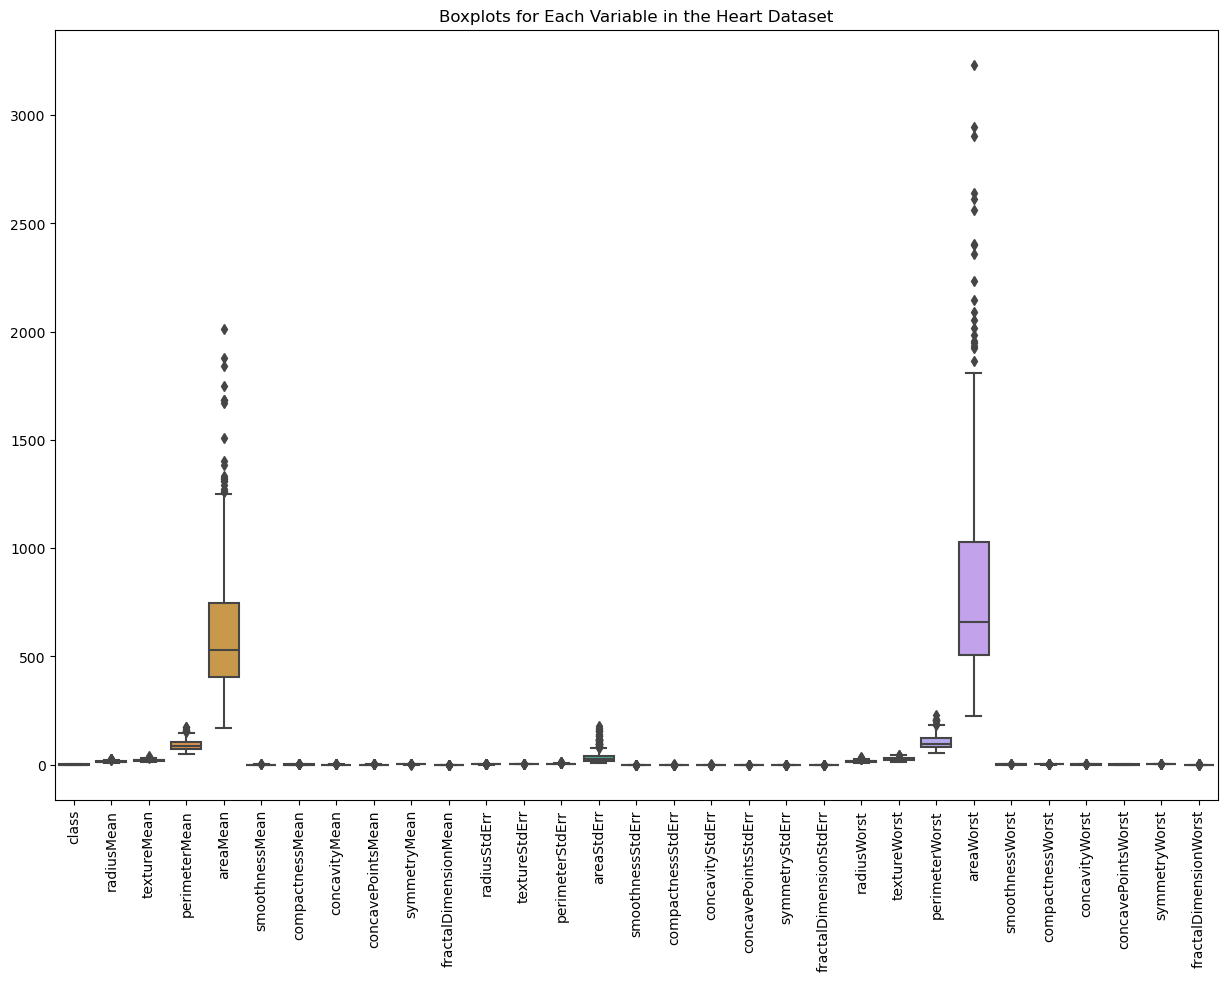

In [81]:
breast_cancer = pd.read_csv("data/breast-cancer/breast-cancer-diagnostic.shuf.lrn.csv", sep=',')
breast_cancer = breast_cancer.drop(columns=["ID"])
breast_cancer.columns = breast_cancer.columns.str.strip() #as one variable is called ' perimeterMean' so there is an extra space in between

print("First 5 rows of the dataset:\n", breast_cancer.head())
print("\nMissing values per variable:\n", breast_cancer.isna().sum())
print("\nSummary statistics:\n", breast_cancer.describe())

#detect outliers using the function from above
outliers = detect_outliers(breast_cancer)

for column, outlier_df in outliers.items():
    print(f"\nOutliers in {column}:\n", outlier_df)

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=breast_cancer)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show()

### Data Preprocessing
The dataset contains no missing values, so no imputation is necessary.
Variable Selection
The ID variable was omitted from the dataset as it carries no diagnostic information.


Outlier Detection: The Interquartile Range (IQR) method was used to identify outliers for each variable. Specifically, we used the IQR multiplied by 1.5 to flag extreme values.

Outlier Treatment via capping:  
Outliers in the following variables were capped to the upper or lower threshold to mitigate their influence on the model:
radiusMean, textureMean, perimeterMean, areaMean, smoothnessMean, compactnessMean, concavityMean, concavePointsMean, symmetryMean, fractalDimensionMean, radiusWorst, textureWorst, perimeterWorst, areaWorst, smoothnessWorst, compactnessWorst, concavityWorst. This makes sense as we only classify as harmful or not, if some value is already 'very' high, it doesn't matter that much if its more extreme.  
Standard Error Variables:  
Outliers in the standard error variables (radiusStdErr, textureStdErr, perimeterStdErr, areaStdErr, smoothnessStdErr, compactnessStdErr, concavityStdErr, concavePointsStdErr, symmetryStdErr, fractalDimensionStdErr) were left unchanged due to concerns over their non-linear structure. Applying scalers or transformations might strip these values of useful variability and information.  
This preprocessing approach aims to prepare the dataset by limiting the impact of extreme values, thus improving the model's robustness without excessively altering potentially meaningful variability in the standard error measurements.

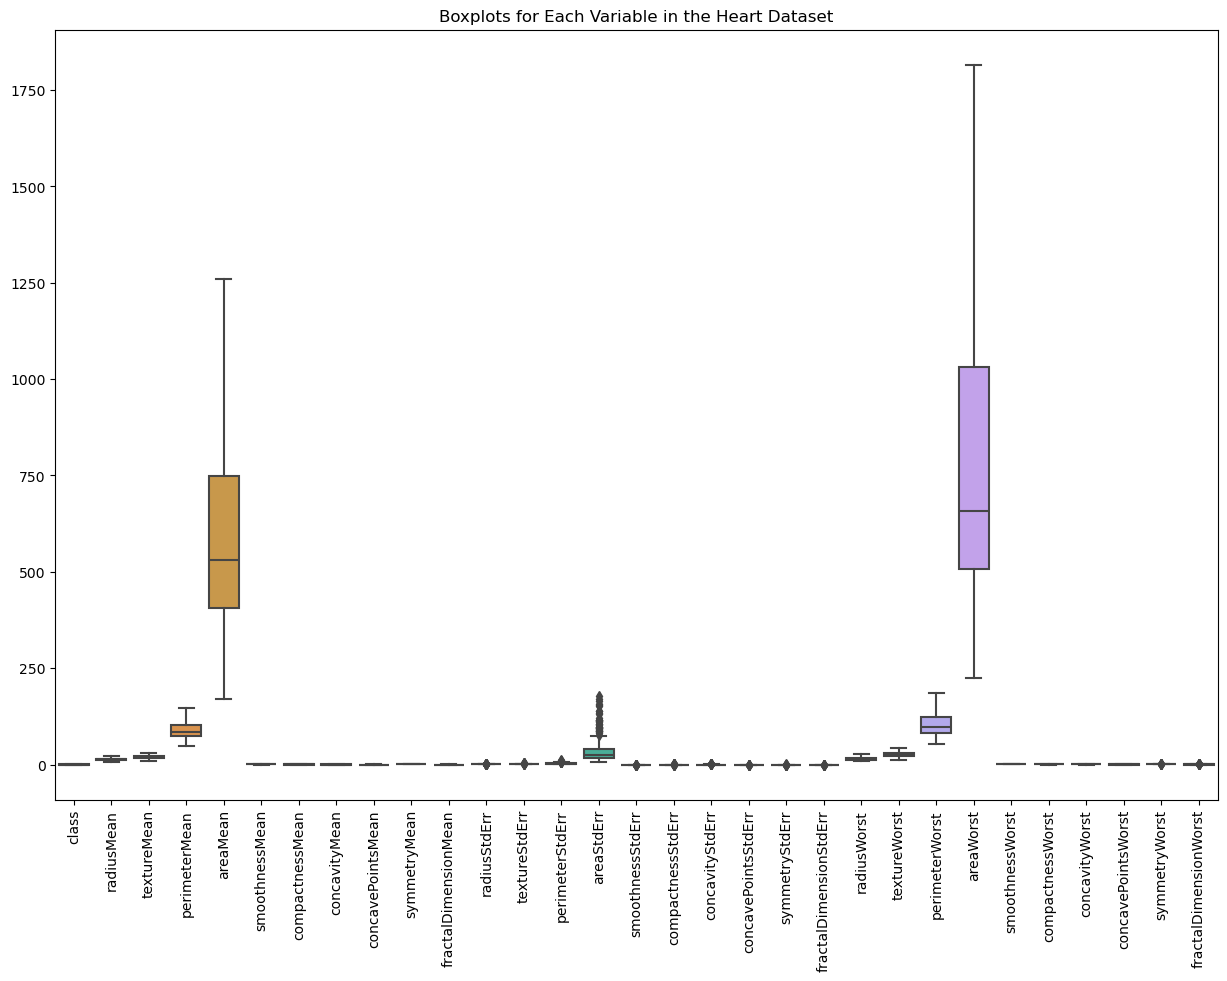

In [82]:
# Define outlier capping function
def cap_outliers(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound,
                       np.where(df[col] < lower_bound, lower_bound, df[col]))
    
# For simplicity, we're treating these as separate categories
cap_columns = ['radiusMean', 'textureMean', 'perimeterMean', 'areaMean', 'smoothnessMean', 'compactnessMean', 'concavityMean', 'concavePointsMean', 'symmetryMean', 'fractalDimensionMean', 'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst', 'smoothnessWorst', 'compactnessWorst', 'concavityWorst']
for col in cap_columns:
    cap_outliers(breast_cancer, col)

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=breast_cancer)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show() 

### Classifier #1: Random Forest
We try out the random forest first. Below is an overview of the main hyperparameters used in this model.

Explicitly Defined Hyperparameters:  
n_estimators - This parameter defines the number of trees in the forest. Using 100 trees provides sufficient ensemble diversity, helping to reduce overfitting while maintaining computational efficiency. This choice was based on a stackexchange discussion: https://stackoverflow.com/questions/34997134/random-forest-tuning-tree-depth-and-number-of-trees. Eventhough this does not exactly apply to our setting, it helps to get a sense for a proper value.

criterion = 'gini': The Gini impurity criterion measures the quality of each split, aiming to increase node purity by favoring partitions with homogenous classes. Although Information Gain (entropy) was considered, it was noted in the lecture that Gini performs similarly in many classification tasks and is computationally efficient. This made Gini a suitable choice for this model.

max_depth - We need to set some limit to the depth of the trees such that we can assure finite computation time. We actually put in place a better suited method as stopping criterion, the impurity decrease.

min_impurity_decrease - This parameter stops further splitting if the reduction in impurity (analogous to Information Gain with criterion='entropy', which we discussed more intensively in the lecture) is below a given threshhold. By setting a minimum threshold for impurity decrease, we avoid creating splits that add minimal information, further controlling tree complexity and enhancing the model’s ability to generalize.

Default Hyperparameters:  
max_features = 'sqrt': The number of features considered for splitting at each node is limited to the square root of the total features. This default setting enhances model diversity by allowing each tree to focus on different subsets of features, reducing overfitting and improving training efficiency.
In this setup, both explicitly defined and default parameters are used to optimize the model’s performance. The adjustments to max_depth and min_impurity_decrease prevent overfitting by limiting unnecessary splits, while n_estimators and criterion maintain model robustness and accuracy. Together, these parameters provide a balanced approach, capturing relevant patterns in the data without overly complex trees.

In [83]:
#define features and target variable
features = ['radiusMean', 'textureMean', 'perimeterMean', 'areaMean', 
            'smoothnessMean', 'compactnessMean', 'concavityMean',
            'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
            'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
            'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
            'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
            'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
            'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
            'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst']

X = breast_cancer[features]
y = breast_cancer['class']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#initialize and train the Random Forest model
n_of_trees = 1000 #https://stackoverflow.com/questions/34997134/random-forest-tuning-tree-depth-and-number-of-trees
rf_model = RandomForestClassifier(
    n_estimators=n_of_trees,
    random_state=seed,  #seed for reproducibility
    bootstrap=True,
    criterion='gini',  # Use impurity as the splitting criterion as information gain stopping criterion is not available which we covered more intensively in the lecture.
    max_depth=20,  #nevertheless we need a definitive stopping criterion
    min_impurity_decrease=0.05  #stop splitting when Information Gain is threshold
)
rf_model.fit(X_train, y_train)

#Evaluate performance
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9883720930232558

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.98      0.99        64
        True       0.96      1.00      0.98        22

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.98        86
weighted avg       0.99      0.99      0.99        86



The model demonstrates high accuracy, with balanced precision and recall across both classes. This indicates that the Random Forest classifier is both effective and reliable at distinguishing between the classes, with minimal misclassification errors. What is unusual is that the n_trees parameter does not affect the output of the table, though min_impurity_decrease does. It’s also striking that the model maintains an accuracy of 75% even for high min_impurity_decrease values, such as 0.4. For some values of min_impurity_decrease, such as in this configuration, the model produces exceptionally high precision and recall: 0.98 precision and 1.00 recall for Class False, and 1.00 precision with 0.96 recall for Class True. We decide to settle with a bit worse model as the hyperparameters look odd and unnatural.

Accuracy:  
The overall accuracy of the model is 97.9%, meaning that the model correctly classified this ratio of the samples in the test set. This high accuracy suggests that the model is effective at distinguishing between the two classes benign vs. malignant tumors.

Precision:
False (Class 0): The precision for the "False" class is 0.96, meaning that 96% of samples predicted as "False" were actually "False." Precision is high, indicating that the model makes few false positive errors for this class.
True (Class 1): Precision for the "True" class is 0.94, meaning that 94% of samples predicted as "True" were indeed "True."
Precision measures the accuracy of positive predictions for each class, and high precision values for both classes suggest that the model is reliable in identifying both "True" and "False" cases without many misclassifications.

Recall:  
False (Class 0): Recall is 0.96, indicating that the model correctly identified 96% of actual "False" cases. This high recall means that the model is capturing most of the true negatives effectively.
True (Class 1): Recall is 0.94 for this class, so the model correctly identified 94% of actual "True" cases.
Recall indicates how well the model identifies all relevant instances of each class, and high recall values for both classes suggest it’s successful in capturing true cases without leaving many undetected.

F1-Score:  
False (Class 0): The F1-score of 0.96 reflects a balance between precision and recall, showing that the model performs consistently well on both metrics for this class.
True (Class 1): The F1-score is 0.94, also indicating strong performance in balancing precision and recall for this class.
The F1-score provides an overall measure of the model’s accuracy for each class, with values close to 1 for both classes, showing balanced performance.

### Classifier #2: K-Nearest Neighbors (KNN)
Even though our results are already extremely good we will now compete against KNN. This time we will try out a plot of k's to find a good choice.

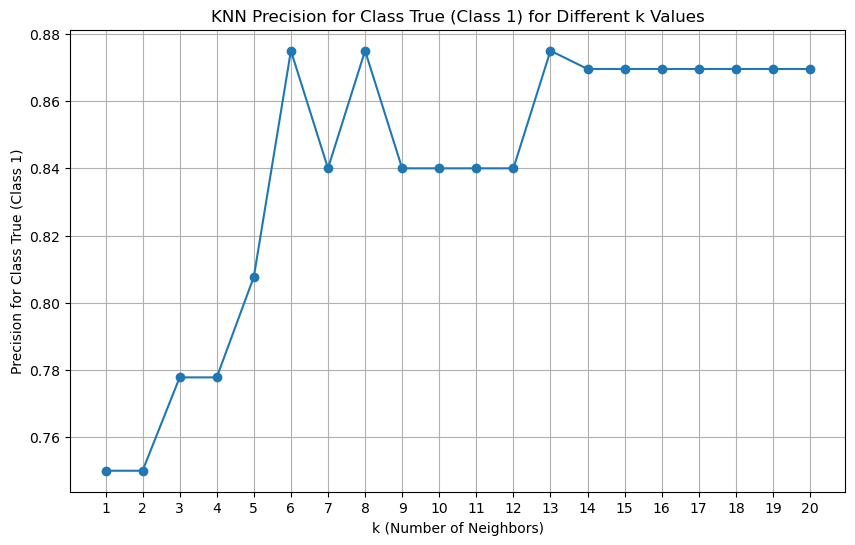

In [84]:
#define features and target variable
features = ['radiusMean', 'textureMean', 'perimeterMean', 'areaMean', 
            'smoothnessMean', 'compactnessMean', 'concavityMean',
            'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
            'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
            'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
            'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
            'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
            'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
            'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst']

X = breast_cancer[features]
y = breast_cancer['class']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#list to store accuracy values for different k


#loop over different k values and calculate accuracy
k_values = range(1, 21)
precision_scores = []

# Loop over different k values and calculate precision for Class 1 (heart disease)
for k in k_values:
    knn_model = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='euclidean'
    )
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    # Calculate precision for Class 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    precision_scores.append(precision)

# Plot precision for Class True (Class 1) for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_scores, marker='o')
plt.title("KNN Precision for Class True (Class 1) for Different k Values")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Precision for Class True (Class 1)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

Visible from the plot and some other plots from other seeds, we find k = 20 looks promising.

In [86]:
k_neighbors = 20
knn_model = KNeighborsClassifier(
    n_neighbors=k_neighbors,
    weights='distance',   # Use distance-weighted voting
    metric='euclidean'    # Euclidean distance for calculating "closeness"
)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)


print("Hyperparameters chosen:\nk_neighbors =", k_neighbors, ", weights = 'distance', metric = 'euclidean'")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Hyperparameters chosen:
k_neighbors = 20 , weights = 'distance', metric = 'euclidean'

Accuracy: 0.9418604651162791

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.95      0.96        64
        True       0.87      0.91      0.89        22

    accuracy                           0.94        86
   macro avg       0.92      0.93      0.92        86
weighted avg       0.94      0.94      0.94        86



As we can see, we yet again acchieve really good results. Precision for True's is strong but accuracy is even stronger. Yet we were not able to beat the random forest model in any of the two metrics.